In [1]:
import os
import requests
import zipfile
import tarfile
import hashlib


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')): #@save
  """Download a file inserted into DATA_HUB, return the local filename."""
  assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
  url, sha1_hash = DATA_HUB[name]
  d2l.mkdir_if_not_exist(cache_dir)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname # Hit cache
  print(f'Downloading {fname} from {url}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

In [3]:
def download_extract(name, folder=None): #@save
  """Download and extract a zip/tar file."""
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    fp = zipfile.ZipFile(fname, 'r')
  elif ext in ('.tar', '.gz'):
    fp = tarfile.open(fname, 'r')
  else:
    assert False, 'Only zip/tar files can be extracted.'
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data_dir
def download_all(): #@save
  """Download all files in the DATA_HUB."""
  for name in DATA_HUB:
    download(name)

In [ ]:
!pip install mxnet gluoncv d2l

In [5]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import gluon, autograd, init, np, npx
from mxnet.gluon import nn
import pandas as pd
npx.set_np()

In [6]:
DATA_HUB['kaggle_house_train'] = ( #@save
  DATA_URL + 'kaggle_house_pred_train.csv',
  '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = ( #@save
  DATA_URL + 'kaggle_house_pred_test.csv',
  'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [9]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)

(2919, 79)


In [11]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [12]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [13]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype=np.float32)
test_features = np.array(all_features[n_train:].values, dtype=np.float32)
train_labels = np.array(
train_data.SalePrice.values.reshape(-1, 1), dtype=np.float32)

In [14]:
loss = gluon.loss.L2Loss()
def get_net():
  net = nn.Sequential()
  net.add(nn.Dense(1))
  net.initialize()
  return net

In [15]:
def log_rmse(net, features, labels):
  # To further stabilize the value when the logarithm is taken, set the
  # value less than 1 as 1
  clipped_preds = np.clip(net(features), 1, float('inf'))
  return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean())

In [16]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  # The Adam optimization algorithm is used here
  trainer = gluon.Trainer(net.collect_params(), 'adam', {
                          'learning_rate': learning_rate, 'wd': weight_decay})
  for epoch in range(num_epochs):
    for X, y in train_iter:
      with autograd.record():
        l = loss(net(X), y)
      l.backward()
      trainer.step(batch_size)
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls

In [17]:
def get_k_fold_data(k, i, X, y):
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j * fold_size, (j + 1) * fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = np.concatenate([X_train, X_part], 0)
      y_train = np.concatenate([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid

In [18]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.169280, valid log rmse 0.156716
fold 2, train log rmse 0.162305, valid log rmse 0.191109
fold 3, train log rmse 0.163799, valid log rmse 0.168123
fold 4, train log rmse 0.167631, valid log rmse 0.154839
fold 5, train log rmse 0.162630, valid log rmse 0.182768
5-fold validation: avg train log rmse: 0.165129, avg valid log rmse: 0.170711


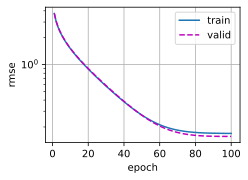

In [19]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [20]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = d2l.numpy(net(test_features))
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162629


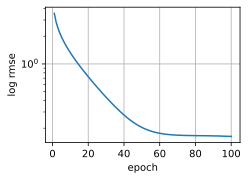

In [21]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)